# FP 43: Raman spectroscopy

Mike Brandt

Juan Carlos Provencio Lameiras

23. March 2023

In [3]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline
import numpy as np
from numpy import exp, sqrt, log, pi, arctan
from scipy.optimize import curve_fit 
from scipy.stats import chi2
from glob import glob
from astropy.io import fits
from astropy.visualization import simple_norm
import matplotlib.patches as mpatches
import statistics as st
import pandas as pd
from scipy.signal import find_peaks
from scipy.ndimage import uniform_filter1d

def fehler(name, G, sig_G, G_lit, sig_G_lit, r = 2, r_lit = 5):
    print(name)
    a = 'Relative error:'
    b = 'Rel. error (comparison): '
    c = 'Absolute error:'
    d = 'Sigma deviation:'
    
    print('Messwerte: '.ljust(len(b)), np.round(G, r))
    print('+/-'.rjust(len(b)), np.round(sig_G, r))
    print('Literaturwerte: '.ljust(len(b)), np.round(G_lit, r_lit))
    print('+/-'.rjust(len(b)), np.round(sig_G_lit, r_lit))
    print('\n')
    print(a.ljust(len(b)), sig_G / G * 100)
    print(b.ljust(len(b)), sig_G_lit / G_lit * 100)
    print(c.ljust(len(b)), G - G_lit)
    print(d.ljust(len(b)), np.abs(G - G_lit) / sqrt(sig_G ** 2 
                                                    + sig_G_lit ** 2),'\n')
    
def fehler_small(name, G, sig_G):
    print(name)
    print('Relativer Fehler: ', sig_G / G * 100)
    

def result(name, G, sig_G, komma, einheit):
    print(name + ' =', np.round(G, komma), '+/-', np.round(sig_G, komma), einheit)
    

def fitparameter(name, G, sig_G, komma, einheit):
    return name + ' =' + str(np.round(G, komma)) + '$\pm$' + str(np.round(sig_G, komma)) + einheit

def chi_sq(test_func, x_val, y_val, sig_y_val, popt, number):
    chi2_ = np.sum((test_func(x_val, *popt) - y_val) ** 2 
                   / sig_y_val ** 2)
    dof = len(y_val) - number
    chi2_red = chi2_ / dof

    print('chi2 =', chi2_)
    print('chi2_red =',chi2_red)

    prob = np.round(1 - chi2.cdf(chi2_,dof), 2) * 100 
    print('Probability =', prob, '%\n')


## Part 1: Characterization of the experimental setup
### Part 1.1 Angular dependency of the Raman-Kantenfilter

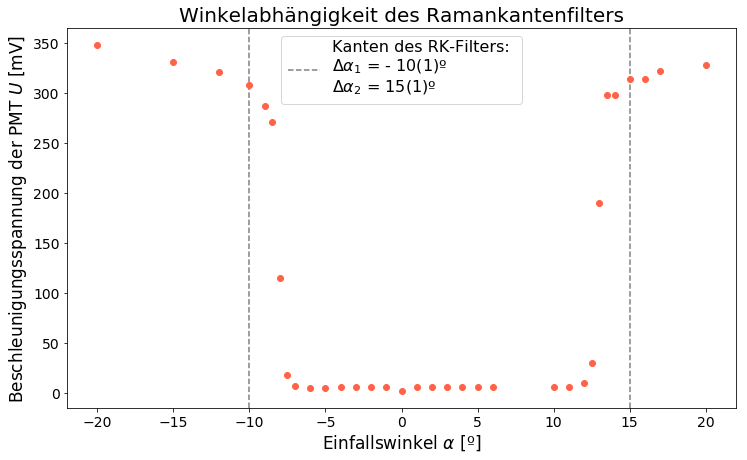

In [4]:
# Measurements for Raman-Kantenfilter
Delta_alpha = np.array([0, 1, 2, 3, 4, 5, 6, 10, 11, 12, 12.5, 13, 13.5, 14, 
                        15, 16, 17, 20, -1, -2, -3, -4, -5, -6, -7, -7.5, -8, 
                        -8.5, -9, -10, -12, -15, -20]) # º
U_1 = np.array([2.56, 6.6, 6.7, 6.7, 6.7, 6.7, 6.7, 6.7, 6.8, 9.9, 30.4, 190, 
                298, 298, 313.8, 313.5, 322, 328, 6.2, 6.2, 6.2, 5.9, 5.8, 5.8,
               7.1, 18.5, 115.3, 270.6, 287.0, 308.0, 320.5, 330.5, 347.7]) # mV
err_U_1 = 0.2 # mV


plt.figure(figsize=(12,7))
plt.title('Winkelabhängigkeit des Ramankantenfilters', size = 20)
plt.errorbar(Delta_alpha, U_1, yerr = err_U_1, fmt = 'o', color = 'tomato')
plt.xlabel('Einfallswinkel $\\alpha$ [º]', size = 17)
plt.xticks(size = 14)
plt.ylabel('Beschleunigungsspannung der PMT $U$ [mV]', size = 17)
plt.yticks(size = 14)
plt.axvline(15, ls = '--', color = 'gray', 
            label = 'Kanten des RK-Filters: \n' + '$\Delta \\alpha_1$ =' 
           + ' - 10(1)º \n' + '$\Delta \\alpha_2$ =' + ' 15(1)º')
plt.axvline(-10, ls = '--', color = 'gray')

plt.legend(loc = 'best', fontsize = 16)
plt.savefig('diagrams/Kantenfilter.png')

Mögliche Fehlerquellen: 
    Menschlich: Es war ziemlich dunkel und man musste mit der Handy-Lampe den Winkel einstellen

### Part 1.2: Voltage characteristic
#### Measurements

In [5]:
U_2 = np.array([1.6, 1.65, 1.7, 1.75, 1.8, 1.85, 1.9, 1.95, 2, 2.05]) # kV
err_U_2 = 0.001 # kV
dwell = 1 # s
counts = np.array([145.20, 222.1, 286.9, 382.3, 486.5, 619.8, 783.7, 927.2, 1084.4, 1271.1])
counts_std = np.array([13.59, 17.23, 10.9, 16.81, 25.54, 24.02, 20.02, 34.03, 27.11, 45.9])

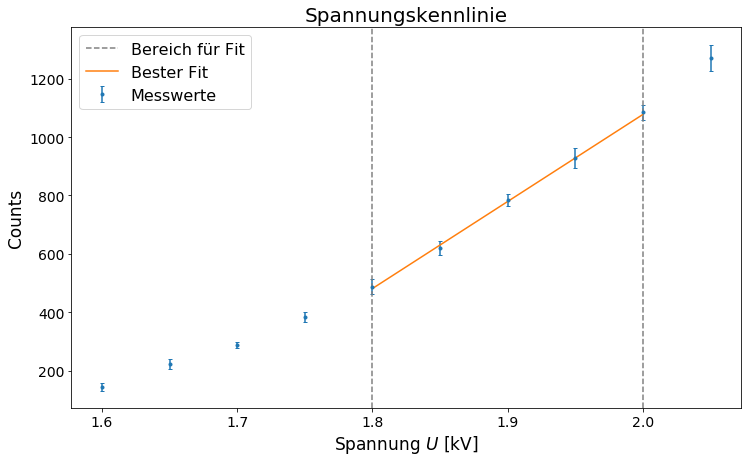

In [6]:
# Plot
a = 4
b = -2

plt.figure(figsize = (12, 7))
plt.title('Spannungskennlinie', size = 20)
plt.errorbar(U_2, counts, yerr = counts_std, fmt = '.', capsize = 2, 
             label = 'Messwerte')
plt.xlabel('Spannung $U$ [kV]', size = 17)
plt.xticks(size = 14)
plt.ylabel('Counts', size = 17)
plt.yticks(size = 14)
plt.axvline(U_2[a], ls = '--', color = 'gray', label = 'Bereich für Fit')
plt.axvline(U_2[b], ls = '--', color = 'gray')

# Fit
def line(x, m, b):
    return m * x + b


popt_12, pcov_12 = curve_fit(line, U_2[a:b], counts[a:b], sigma = counts_std[a:b])

m = popt_12[0]
err_m = sqrt(pcov_12[0, 0])

x = np.linspace(U_2[a], U_2[b], 100)

plt.plot(x, line(x, *popt_12), label = 'Bester Fit')
plt.legend(loc = 'best', fontsize = 16)
plt.savefig('diagrams/Spannungskennlinie.png')

An dieser Stelle hätte man eine Sättigung der Counts mit zunehmender Spannung erwartet. Dies scheint bei uns nicht der Fall sein beim Erreichen der Grenzenspannung 2,050 kV. Im Gegenteil, steigen die Counts sogar weiter. Wir haben nicht mit höheren Spannungen fortgefahren, wo dieses Verhältnis vielleicht zu sehen gewesen wäre. Als Beschleunigungsspannung nehmen wir 1,900 kV, denn es in ziemlich genau in der Mitte unseres ausgewählten linearen Bereiches liegt und es besteht somit nicht die Gefahr, dass wir über die sichere Grenze laufen, oder dass die Spannung nicht ausreicht.

## Teil 2: Raman Spektren verschiedener Gasen

### Untergrundabzug

In [7]:
def comma_to_float(file):
    return float(file.decode('utf-8').replace(',','.'))


# Create command to parse the data and store the respective columns in arrays
def data(file):
    '''
    We just want to load the data into numpy arrays to work with
    '''
    data_0 = np.loadtxt('data/' + file, usecols = (0), 
                      converters = {0: comma_to_float}, unpack = True)
    data_1 = np.loadtxt('data/' + file, usecols = (1), 
                      converters = {1: comma_to_float}, unpack = True)
    data_2 = np.loadtxt('data/' + file, usecols = (2), 
                      converters = {2: comma_to_float}, unpack = True)
    data_3 = np.loadtxt('data/' + file, usecols = (3), 
                      converters = {3: comma_to_float}, unpack = True)
    return data_0, data_1, data_2, data_3


# Correct measurements and output wl, mean and std
def corr_data_pd(measurement, untergrund):

    untergrund_list = data(untergrund)
    measurement_list = data(measurement)
    
    # Group measurements with a panda DataFrame
    df_unt = pd.DataFrame({'Scan':untergrund_list[0], 
                           'Number':untergrund_list[1], 
                           'Wavelength':untergrund_list[2], 
                           'Meas':untergrund_list[3]})
    df_unt_wl = df_unt.groupby('Wavelength')
    
    df_meas = pd.DataFrame({'Scan':measurement_list[0], 
                            'Number':measurement_list[1], 
                            'Wavelength':measurement_list[2], 
                            'Meas':measurement_list[3]})
    df_meas_wl = df_meas.groupby('Wavelength')
    
    df_meas_wl_mean = df_meas_wl.mean()
    df_meas_wl_std = df_meas_wl.std()
    
    scans = np.array([])
    meass = []
    unter = np.array([])
    wls = np.array([])
    
    # Correct the measurements and mean them
    for wl in df_meas_wl:
        a = df_unt_wl.get_group(wl[0]).mean()[3]
        unter = np.append(unter, a)
        wls = np.append(wls, wl[0])
    
    data_corr = df_meas_wl_mean['Meas'] - unter
    data_corr_std = df_meas_wl_std['Meas']
    
    return wls, data_corr.values, data_corr_std.values

In [8]:
# Saved data
data_O2 = corr_data_pd('O2', 'O2-Untergrund')
data_H2 = corr_data_pd('H2', 'H2-Untergrund')
data_N2 = corr_data_pd('N2', 'N2-Untergrund')
data_D2 = corr_data_pd('D2', 'D2-Untergrund')
data_Para = corr_data_pd('Para', 'Para-Untergrund')

HIER WÄRE BIN[1] GEWESEN

### Wasserstoffspektrum

In [9]:
# Create command to automatically plot the spectrum of our data
def plotter(element, data):
    plt.figure(figsize = (12, 7))
    plt.title('Raman-Spektrum: ' + element, size = 20)
    plt.xlabel('Wellenlänge $\lambda$ [nm]', size = 17)
    plt.xticks(size = 14)
    plt.ylabel('Counts', size = 17)
    plt.yticks(size = 14)
    plt.errorbar(data[0], data[1], yerr = data[2], fmt = '+', 
                 capsize = 2)

Wir erkennen am Spektrum des Para-Wasserstoffs und an den grossen statistischen Ungenauigkeiten, dass sich unsere Methode zur Mittlung von den Werten nicht besonders eignet, da der Inhalt des Para-Wasserstoffs mit der Zeit sinkt. Dafür nehmen wir für die Bestimmung der Peaks nur die ersten 6 Messungen, wie bei bei den anderen Spektren. Der Para-Wasserstoff-Inhalt wäre nach diesen Messungen nur um [HEY] % kleiner.

In [10]:
# Correct measurements between scans [a:b]
def corr_data_pd_ab(measurement, untergrund, a, b):

    untergrund_list = data(untergrund)
    measurement_list = data(measurement)
    
    # Group measurements with a panda DataFrame
    df_unt = pd.DataFrame({'Scan':untergrund_list[0], 
                           'Number':untergrund_list[1], 
                           'Wavelength':untergrund_list[2], 
                           'Meas':untergrund_list[3]})
    df_unt_wl = df_unt.groupby('Wavelength')
    df_unt_wl_mean = df_unt_wl['Meas'].mean()
    
    df_meas = pd.DataFrame({'Scan':measurement_list[0], 
                            'Number':measurement_list[1], 
                            'Wavelength':measurement_list[2], 
                            'Meas':measurement_list[3]})
    df_meas_wl = df_meas.groupby('Wavelength')
    
    df_meas_2 = pd.DataFrame()
    
    wls = np.array([])
    
    for wl in df_meas_wl:
        wls = np.append(wls, wl[0])
    
    for i in range(a, b + 1):
        df_meas_ab_i = df_meas.groupby('Scan').get_group(i)
        df_meas_ab_i = df_meas_ab_i.groupby('Wavelength')['Meas'].mean()
        df_meas_ab_i = df_meas_ab_i - df_unt_wl_mean
        
        df_meas_2 = df_meas_2.append(df_meas_ab_i)
    
    df_meas_2_mean = df_meas_2.mean()
    df_meas_2_std = df_meas_2.std()
        
    return wls, df_meas_2_mean.values, df_meas_2_std.values

HIER WÄRE BIN[2] GEWESEN

#### Intensität und Position der Peaks

In [11]:
def gaussian(x, a, b, c, d):
    return a * exp( - (x - b) ** 2 / (2 * c ** 2) ) + d


def double_gaussian(x, a1, b1, c1, a2, b2, c2, d):
    return gaussian(x, a1, b1, c1, d) + gaussian(x, a2, b2, c2, d)


def triple_gaussian(x, a1, b1, c1, a2, b2, c2, a3, b3, c3, d):
    return (gaussian(x, a1, b1, c1, d = 0) 
            + gaussian(x, a2, b2, c2, d = 0) 
            + gaussian(x, a3, b3, c3, d))


def quad_gaussian(x, a1, b1, c1, a2, b2, c2, a3, b3, c3, a4, b4, c4, d):
    return (gaussian(x, a1, b1, c1, d = 0) 
            + gaussian(x, a2, b2, c2, d = 0) 
            + gaussian(x, a3, b3, c3, d = 0) 
            + gaussian(x, a4, b4, c4, d))


''' Global fit function: 
Take the whole range and try to fit at least both big peaks with a double gaussian,
a quad or triple gaussian is too ambitious. 
'''
def fitter(element, data, function, p_0, label):
    popt, pcov = curve_fit(function, data[0], data[1], p0 = p_0)
    
    plotter(element, data)

    x_lin = np.linspace(data[0][0], data[0][-1], 1000)
    plt.plot(x_lin, function(x_lin, *popt), label = label, linewidth = 3)
    
    plt.legend(loc = 'best')
    
    return popt, pcov


'''Local fit function:
Zoom in on a specific range (limit_a:limit_b) and try to fit the smaller peaks there
'''
#                Element  File  For fit, in nm    For fit        Label
def fitter_small(element, data, limit_a, limit_b, function, p_0, label):
    # limit_ab given in nm, turn to index:
    
    Delta_x = np.round(data[0][1][0] - data[0][0][0], 2)
    
    a = int(np.round((limit_a - data[0][0][0]) / Delta_x, 0))
    b = int(np.round((limit_b - data[0][0][0]) / Delta_x, 0))
    
    
    popt, pcov = curve_fit(function, data[0][a:b][:,0], data[0][a:b][:,1], p0 = p_0)
    
    x_lin = np.linspace(data[0][a:b][0, 0], data[0][a:b][-1, 0], 1000)
    plt.plot(x_lin, function(x_lin, *popt), label = label, linewidth = 3)
    
    plt.legend(loc = 'upper left')

    return popt, pcov


# Box style
props = dict(boxstyle='round', facecolor='white', alpha=0.5)


'''
Create a function to automatically output all parameters in a nice way'''
def announcer(params, err_params, labels, I = 'J'):
    a_s, err_a_s = params[0::3][:-1], err_params[0::3][:-1]
    b_s, err_b_s = params[1::3], err_params[1::3]
    c_s, err_c_s = params[2::3], err_params[2::3]
    I_s = a_s * sqrt(2 * pi) * c_s
    print('Fitparameters:\n')
    for i in range(len(a_s)):
        print(I + ' = {}: b = {} +/- {} [nm], a = {} +/- {}, c = {} +/- {} [nm], Intensität = {}'.
              format(labels[i], 
                     round(b_s[i], 2), 
                     round(err_b_s[i], 2), 
                     round(a_s[i], 2), 
                     round(err_a_s[i], 2),
                     round(c_s[i], 2),
                     round(err_c_s[i], 2),
                     round(I_s[i], 0)
                    ))
    print()
    
# Texter
'''Create a function to automatically plt.text all relevant parameters
Input the title (element), params (popt), err_params (diag(pcov)), 
labels you want, and the position where the box should be.

Including some default settings to be able to change them for the 
O2, N2 measurement'''
def textstrer(title, params, err_params, labels, a, b, I = 'J', offset = -30):
    b_s, err_b_s = params[1::3], 2 * params[2::3]
    textstr = np.array([title + '\n'])
    
    for i in range(len(b_s)):
        textstr = np.append(textstr, 
                            '$\lambda_{} = {} \pm {}$ [nm]'.
                            format(labels[i],
                                  np.round(b_s[i], 1),
                                   np.round(err_b_s[i], 1)
                                  )) # Create a textstring w/ all parameters
        plt.text(b_s[i] - 1, offset, I + ' = {}'.format(labels[i]),
                fontsize = 14) # Plot under every peak its label
        
    plt.text(a, b, ''.join(map(lambda x: x[:] + '\n', textstr)),
            verticalalignment = 'top', fontsize = 14, bbox = props)

HIER WÄRE BIN[5] GEWESEN

##### H2

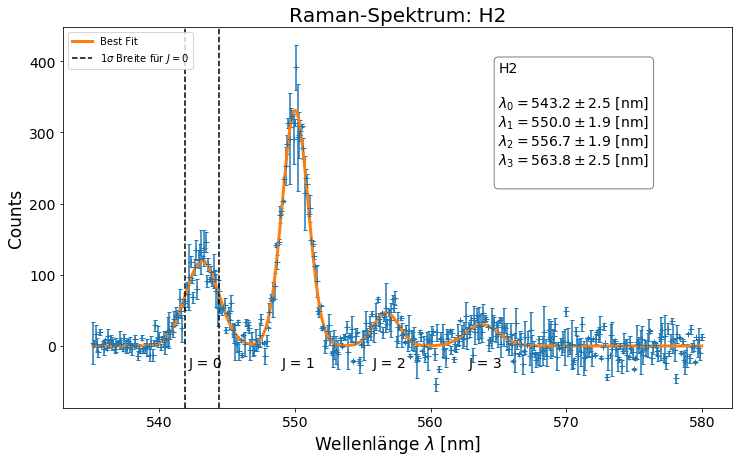

In [12]:
p0_H2        = [120, 543.1, 1.8, 0]
p0_H2_double = [120, 543.1, 1.8, 400, 549,    1, 0]
p0_H2_quad   = [120, 542.8, 2,  450, 550.07, 1,   30,  
                557.53, 3, 20, 565.2, 1, 0]

# Fit
fit_H2 = fitter('H2', data_H2, quad_gaussian, p0_H2_quad, 'Best Fit')


# Results
params = fit_H2[0]
err_params = sqrt(np.diag(fit_H2[1]))

# HIER WÄRE BIN[9] GEWESEN

t = 1

lambdas_H2, err_lambdas_H2 = params[1::3], t * params[2::3]
as_H2, err_as_H2 = params[0::3][:-1], err_params[0::3][:-1]
cs_H2, err_cs_H2 = params[2::3], err_params[2::3]


plt.axvline(lambdas_H2[0] - err_lambdas_H2[0], ls = '--', color = 'black', 
            label = str(t) + '$\sigma$ Breite für $J = 0$')
plt.axvline(lambdas_H2[0] + err_lambdas_H2[0], ls = '--', color = 'black')

plt.legend(loc = 'upper left')


# Texts
labels = ['0', '1', '2', '3']
textstrer('H2', params, err_params, labels, 565, 400)

# HIER WÄRE BIN[8] GEWESEN

plt.savefig('diagrams/Raman_Spektrum_H2.png')

HIER WÄRE BIN[6] GEWESEN

In [13]:
announcer(params, err_params, labels)

Fitparameters:

J = 0: b = 543.15 +/- 0.05 [nm], a = 119.58 +/- 4.03, c = 1.23 +/- 0.05 [nm], Intensität = 370.0
J = 1: b = 550.01 +/- 0.01 [nm], a = 330.93 +/- 4.56, c = 0.95 +/- 0.02 [nm], Intensität = 791.0
J = 2: b = 556.72 +/- 0.1 [nm], a = 47.12 +/- 4.6, c = 0.94 +/- 0.11 [nm], Intensität = 111.0
J = 3: b = 563.8 +/- 0.19 [nm], a = 30.2 +/- 4.02, c = 1.24 +/- 0.2 [nm], Intensität = 94.0



HIER WÄRE BIN[3] GEWESEN

HIER WÄRE BIN[4] GEWESEN

##### D2

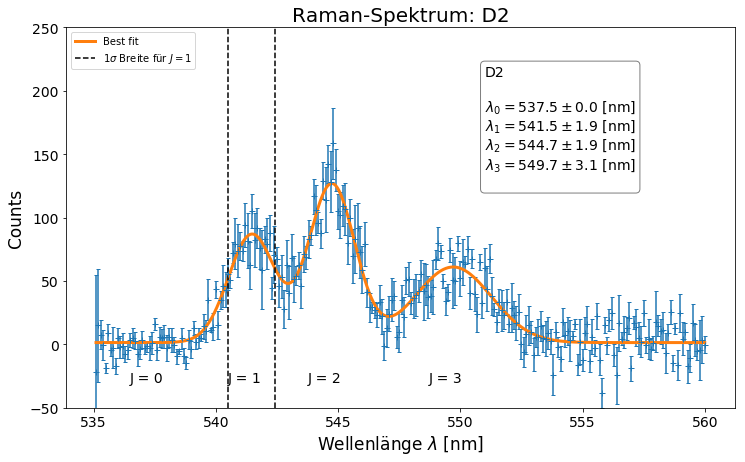

In [14]:
#           a_1  b_1  c_1 a_2 b_2  c_2 d
p0_D2_triple = [100, 542, 1, 150, 545, 1, 50, 550, 1, 0]

# Plot for D2 spectrum
fit_D2 = fitter('D2', data_D2, triple_gaussian, p0_D2_triple, 'Best fit')

# Results
params_J1 = np.array([1, 537.48, 0])
err_params_J1 = np.array([0, 0, 1])
params = np.append(params_J1, fit_D2[0])
err_params = np.append(err_params_J1, sqrt(np.diag(fit_D2[1])))

lambdas_D2, err_lambdas_D2 = params[1::3], t * params[2::3]

# HIER WÄRE BIN[10] GEWESEN

# lambda_1 not found, literature value = 537.48
lambdas_D2 = np.array([*lambdas_D2]) 
err_lambdas_D2 = np.array([*err_lambdas_D2])




plt.axvline(lambdas_D2[1] - err_lambdas_D2[1], ls = '--', color = 'black', 
            label = str(t) + '$\sigma$ Breite für $J = 1$')
plt.axvline(lambdas_D2[1] + err_lambdas_D2[1], ls = '--', color = 'black')


plt.legend(loc = 'upper left')

# Outputs
textstrer('D2', params, err_params, labels, 551, 220)

# HIER WÄRE BIN[11] GEWESEN

plt.ylim(-50, 250)


plt.savefig('diagrams/Raman_Spektrum_D2.png')

In [15]:
announcer(params, err_params, labels)

Fitparameters:

J = 0: b = 537.48 +/- 0.0 [nm], a = 1.0 +/- 0.0, c = 0.0 +/- 1.0 [nm], Intensität = 0.0
J = 1: b = 541.47 +/- 0.06 [nm], a = 85.26 +/- 3.92, c = 0.96 +/- 0.06 [nm], Intensität = 204.0
J = 2: b = 544.75 +/- 0.04 [nm], a = 124.82 +/- 3.98, c = 0.95 +/- 0.05 [nm], Intensität = 297.0
J = 3: b = 549.71 +/- 0.09 [nm], a = 59.6 +/- 3.13, c = 1.57 +/- 0.11 [nm], Intensität = 234.0



HIER WÄRE BIN[7] GEWESEN, ICH HABE ES AUSVERSEHEN GELÖSCHT OOPS

#### Rotational constants

In [16]:
# Constants
lambda0 = 532.25 # nm
v0 = 1 / lambda0 # nm^1

def rot_B(lambdas, err_lambdas): # lambdas in nm
    B = np.array([])
    err_B = np.array([])
    
    for j in range(len(lambdas)):
        b = 1 / (4 * j + 6) * (v0 - 1 / lambdas[j]) * 1e7
        err_b = 1 / (4 * j + 6) * err_lambdas[j] / (lambdas[j]) ** 2 * 1e7
        B = np.append(B, b)
        err_B = np.append(err_B, err_b)
        
    return B, err_B


# H2
B_H2, err_B_H2 = rot_B(lambdas_H2, err_lambdas_H2)
B_H2_mean, B_H2_std = np.mean(B_H2), np.std(B_H2)


# D2
B_D2, err_B_D2 = rot_B(lambdas_D2, err_lambdas_D2)
B_D2_mean, B_D2_std = np.mean(B_D2), np.std(B_D2)


# Ratios
B_HD_mean = B_H2_mean / B_D2_mean
err_B_HD_mean = sqrt( (B_H2_std / B_D2_mean) ** 2 
                     + (B_H2_mean * B_D2_std / (B_D2_mean) ** 2) ** 2 )

B_HD_0 = B_H2[0] / B_D2[0]
err_B_HD_0 = sqrt( (err_B_H2[0] / B_D2[0]) ** 2 
                  + (B_H2[0] * err_B_D2[0] / (B_D2[0]) ** 2) ** 2 )

B_HD = B_H2 / B_D2
err_B_HD = sqrt( (err_B_H2 / B_D2) ** 2 + (B_H2 * err_B_D2 / (B_D2 ** 2)) ** 2)

In [17]:
print('Results: Rotational constant\n')
result('B_H2', B_H2, err_B_H2, 0, '[cm^-1]')
result('B_H2_mean', B_H2_mean, B_H2_std, 1, '[cm^-1]')
print('\n')
result('B_D2', B_D2, err_B_D2, 0, '[cm^-1]')
result('B_D2_mean', B_D2_mean, B_D2_std, 0, '[cm^-1]')
print('\n')
result('All ratios', B_HD, err_B_HD, 2, '')
print('\n')
result('Ratio of means', B_HD_mean, err_B_HD_mean, 2, '')
#print('\n')
#result('Best ratio: 0->2', B_HD_0, err_B_HD_0, 2, '')

Results: Rotational constant

B_H2 = [63. 61. 59. 58.] +/- [7. 3. 2. 2.] [cm^-1]
B_H2_mean = 60.2 +/- 1.7 [cm^-1]


B_D2 = [30. 32. 31. 33.] +/- [0. 3. 2. 3.] [cm^-1]
B_D2_mean = 32.0 +/- 1.0 [cm^-1]


All ratios = [2.06 1.9  1.92 1.76] +/- [0.23 0.22 0.16 0.17] 


Ratio of means = 1.91 +/- 0.08 


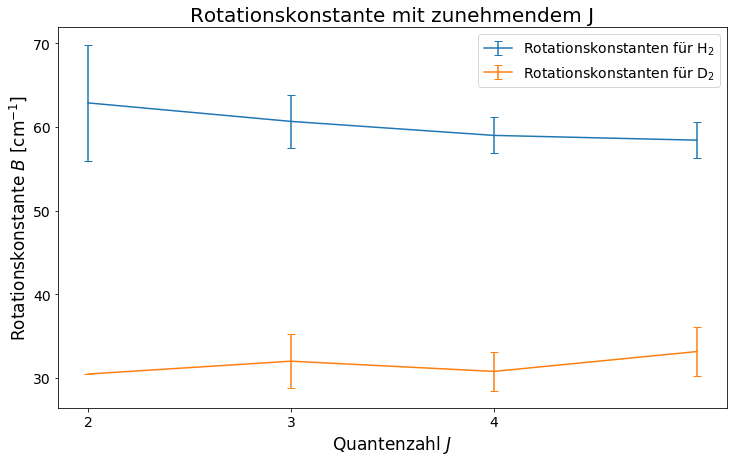

In [18]:
# Validity of assumption: rigid rotator
x_123 = np.array([1, 2, 3, 4])

plt.figure(figsize = (12, 7))
plt.title('Rotationskonstante mit zunehmendem J', size = 20)
plt.errorbar(x_123, B_H2, yerr = err_B_H2, capsize = 4, 
             label = 'Rotationskonstanten für H$_2$')
plt.errorbar(x_123, B_D2, yerr = err_B_D2, capsize = 4,
            label = 'Rotationskonstanten für D$_2$')
plt.xlabel('Quantenzahl $J$', size = 17)
plt.xticks(size = 14)
plt.ylabel('Rotationskonstante $B$ [cm$^{-1}$]', size = 17)
plt.yticks(size = 14)
plt.xticks([1, 2, 3], labels = ['2', '3', '4'])

plt.legend(loc = 'best', fontsize = 14)

plt.savefig('diagrams/Rotationskonstanten.png')

#### Purity of Para-H2

#### Purity as a function of scan number

In [19]:
# Correct measurements for Para-H2 and separate by scan number
def corr_para_panda(measurement, untergrund):

    untergrund_list = data(untergrund)
    
    # Group measurements with a panda DataFrame
    
    df_unt = pd.DataFrame({'Scan':untergrund_list[0], 
                           'Number':untergrund_list[1], 
                           'Wavelength':untergrund_list[2], 
                           'Meas':untergrund_list[3]})
    
    df_unt = df_unt.groupby('Wavelength')
    
    measurement_list = data(measurement)
    
    df_meas = pd.DataFrame({'Scan':measurement_list[0], 
                            'Number':measurement_list[1], 
                            'Wavelength':measurement_list[2], 
                            'Meas':measurement_list[3]})
    
    # Sort measurements by Scan number and Wavelength
    
    df_meas_sc = df_meas.groupby('Scan')
    df_meas_wl = df_meas.groupby('Wavelength')
    
    scans = np.array([])
    meass = []
    unter = np.array([])
    
    # Make an array with the scan number and the respective measurements
    
    for wl in df_meas_wl:
        a = df_unt.get_group(wl[0]).mean()[3]
        
        unter = np.append(unter, a)
        
    
    for sc_number in df_meas_sc:
        scans = np.append(scans, sc_number[0])
        
        wls = np.array(sc_number[1]['Meas']) - unter
        
        meass.append(wls)

    return scans, meass

    
data_Para_df = corr_para_panda('Para', 'Para-Untergrund')

In [20]:
data_Para_df_rm = data_Para_df[0], uniform_filter1d(data_Para_df[1], size = 6)

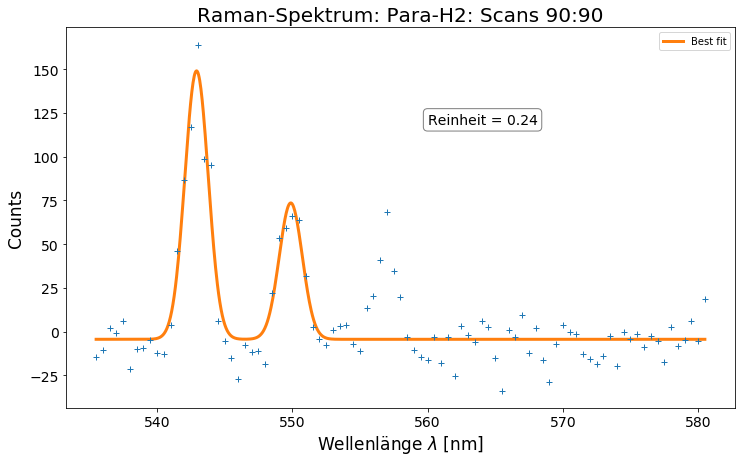

In [21]:
# Find the peak heights for every scan and determine the purity
I_o_H2 = as_H2[0] * sqrt(2 * pi * cs_H2[0] ** 2)
I_p_H2 = as_H2[1] * sqrt(2 * pi * cs_H2[1] ** 2)

a = 90
b = 90
data_Para_ab = corr_data_pd_ab('Para', 'Para-Untergrund', a, b)

#        a_1  b_1  c_1 a_2 b_2  c_2 d
p0_para_H2_double = [50, 542.8, 1, 70, 550.7, 1, 0]


# Plot for Para-H2 spectrum
fit_para_H2 = fitter('Para-H2: Scans ' + str(a) + ':' + str(b), 
                        data_Para_ab, double_gaussian,
                        p0_para_H2_double, 'Best fit')

params = fit_para_H2[0]

I_p_para_H2_ab = params[0] * sqrt(2 * pi * params[2] ** 2)
I_o_para_H2_ab = params[3] * sqrt(2 * pi * params[5] ** 2)

gp_ab = 3 * (I_p_H2 / I_o_H2) * (I_o_para_H2_ab / I_p_para_H2_ab)
purity_ab = 1 / (1 + gp_ab)

plt.text(560, 125, 'Reinheit = ' + str(np.round(purity_ab, 2)), fontsize = 14, 
         verticalalignment = 'top', bbox = props)

plt.savefig('diagrams/Raman_Spektrum_Para_90.png')

In [22]:
p0_para_H2_purity = [50, 542.8, 1, 70, 550.7, 1, 0]

def purity(data, p_0):
    wls = np.linspace(535.5, 580.5, int((580.5 - 535) / 0.5))
    
    
    gps = np.array([])
    
    for scan in data[0] - 1:
        x_scan = data[0][int(scan)]
        y_scan = data[1][int(scan)]
        
        try:
            popt, pcov = curve_fit(double_gaussian, wls, y_scan, p0 = p_0)
            I_p_para = popt[0] * sqrt(2 * pi * popt[2] ** 2)
            I_o_para = popt[3] * sqrt(2 * pi * popt[2] ** 2)
            
            gp = 3 * (I_p_H2 / I_o_H2) * (I_o_para / I_p_para)
            
            gps = np.append(gps, gp)
        except:
            I_o_para = 1000
            I_p_para = 1
            
            gp = 3 * (I_p_H2 / I_o_H2) * (I_o_para / I_p_para)
            
            gps = np.append(gps, gp)
            
    purities = 1 / (1 + gps)
    
    return purities
            

pur_data = purity(data_Para_df, p0_para_H2_purity)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


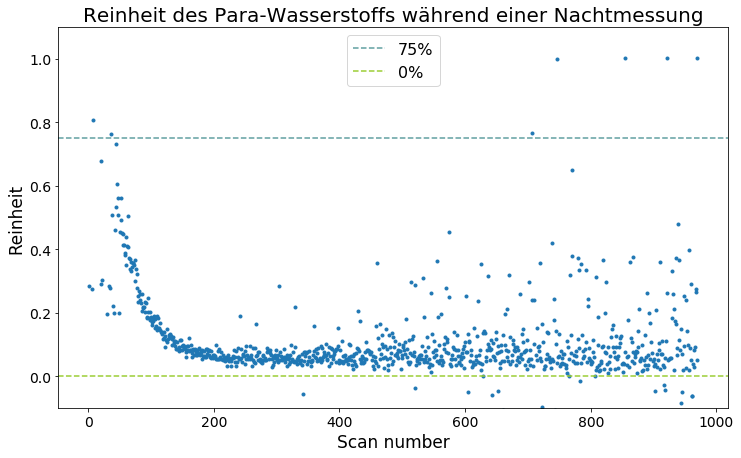

In [23]:
# Plot results
plt.figure(figsize = (12, 7))
plt.plot(data_Para_df[0], pur_data, '.')
plt.title('Reinheit des Para-Wasserstoffs während einer Nachtmessung', size = 20)
plt.xlabel('Scan number', size = 17)
plt.xticks(size = 14)
plt.ylabel('Reinheit', size = 17)
plt.yticks(size = 14)
plt.axhline(0.75, ls = '--', label = '75%', color = 'cadetblue')
plt.axhline(0, ls = '--', label = '0%', color = 'yellowgreen')
plt.ylim(-0.1, 1.1)

plt.legend(loc = 'best', fontsize = 16)
plt.savefig('diagrams/Reinheit_Para_H2.png')

### Sauerstoff- und Stickstoffspektrum

In [24]:
# Calculate the wavenumber vor the vibrational modes
def v_vib(lambdas, err_lambdas):
    vvib = (1 / v0) - (1 / lambdas) * 1e7 # cm^-1
    err_vvib = err_lambdas / (lambdas ** 2) * 1e7

    return vvib, err_vvib

-16682.818638735138


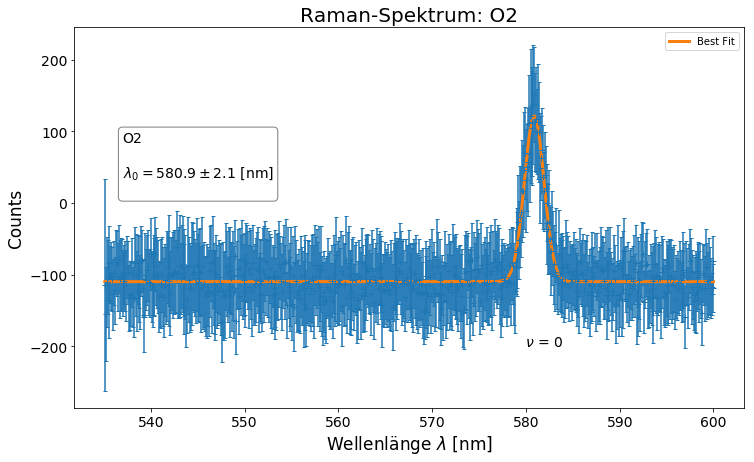

In [25]:
p0_O2 = [100, 580, 2, 0]

fit_O2 = fitter('O2', data_O2, gaussian, p0_O2, 'Best Fit')

params = fit_O2[0]
err_params = sqrt(np.diag(fit_O2[1]))

lambda_O2, err_lambda_O2 = params[1], t * params[2]

# Outputs
labels = ['0']
textstrer('O2', params, err_params, labels, 537, 100, I = '$\\nu$', offset = -200)

v_vib_O2, err_v_vib_O2 = v_vib(lambda_O2, err_lambda_O2)
print(v_vib_O2)

plt.savefig('diagrams/Raman_Spektrum_O2.png')

In [26]:
announcer(params, err_params, ['0'], I = 'nu',)

Fitparameters:

nu = 0: b = 580.89 +/- 0.03 [nm], a = 231.19 +/- 4.99, c = 1.05 +/- 0.03 [nm], Intensität = 606.0



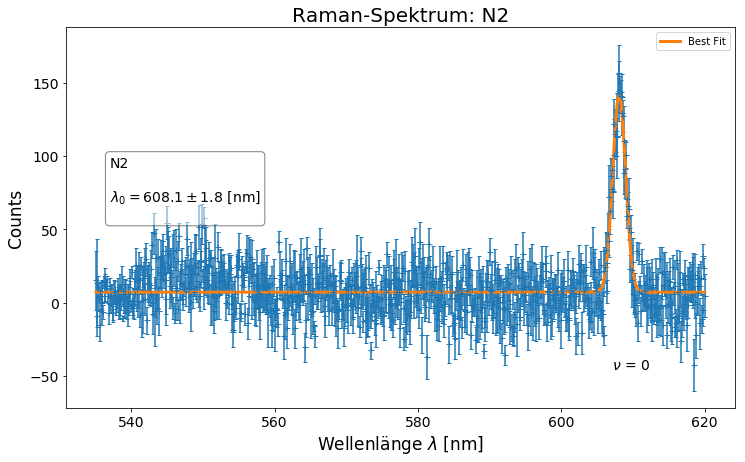

In [27]:
p0_N2 = [100, 608, 2, 0]

fit_N2 = fitter('N2', data_N2, gaussian, p0_N2, 'Best Fit')

params = fit_N2[0]
err_params = sqrt(np.diag(fit_N2[1]))

lambda_N2, err_lambda_N2 = params[1], t * params[2]

# Outputs
textstrer('N2', params, err_params, labels, 537, 100, I = '$\\nu$', offset = -45)

plt.savefig('diagrams/Raman_Spektrum_N2.png')

In [28]:
announcer(params, err_params, ['0'], I = 'nu')

Fitparameters:

nu = 0: b = 608.06 +/- 0.03 [nm], a = 134.3 +/- 4.37, c = 0.91 +/- 0.03 [nm], Intensität = 305.0



## Diskussion

In [29]:
# Literaturwerten
lambdas_H2_lit = np.array([542.8, 550.07, 557.53, 565.20]) # nm
err_lambdas_H2_lit = np.zeros(4)

B_H2_lit, err_B_H2_lit = 60.853, 0

lambdas_D2_lit = np.array([537.48, 541.02, 544.6, 548.24])
err_lambdas_D2_lit = np.zeros(4)

B_D2_lit, err_B_D2_lit = 30.443, 0

m_p = 1.00728
m_n = 1.00866

m_H = m_p
m_D = m_p + m_n

B_HD_lit, err_B_HD_lit = B_H2_lit / B_D2_lit, 0
B_HD_theo, err_B_HD_theo = m_D / m_H, 0

lambda_O2_lit, err_lambda_O2_lit = 581.13, 0
lambda_N2_lit, err_lambda_N2_lit = 607.6, 0

In [30]:
fehler('Wellenlängen H_2:', lambdas_H2, err_lambdas_H2, lambdas_H2_lit, 
       err_lambdas_H2_lit, 1)

Wellenlängen H_2:
Messwerte:                [543.2 550.  556.7 563.8]
                      +/- [1.2 1.  0.9 1.2]
Literaturwerte:           [542.8  550.07 557.53 565.2 ]
                      +/- [0. 0. 0. 0.]


Relative error:           [0.22710658 0.17347298 0.16852041 0.21954861]
Rel. error (comparison):  [0. 0. 0. 0.]
Absolute error:           [ 0.35489826 -0.06303674 -0.81069689 -1.39695834]
Sigma deviation:          [0.28770702 0.06606839 0.86411136 1.12856179] 



In [31]:
fehler('Wellenlängen D_2:', lambdas_D2, err_lambdas_D2, lambdas_D2_lit,
      err_lambdas_D2_lit, 1)

Wellenlängen D_2:
Messwerte:                [537.5 541.5 544.7 549.7]
                      +/- [0.  1.  0.9 1.6]
Literaturwerte:           [537.48 541.02 544.6  548.24]
                      +/- [0. 0. 0. 0.]


Relative error:           [0.         0.17651881 0.17399635 0.28535347]
Rel. error (comparison):  [0. 0. 0. 0.]
Absolute error:           [0.         0.4542928  0.14585735 1.47090103]
Sigma deviation:          [       nan 0.47529913 0.15388428 0.93770439] 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


In [32]:
fehler('Rotationskonstante H_2:', B_H2, err_B_H2, B_H2_lit, err_B_H2_lit, 0)

Rotationskonstante H_2:
Messwerte:                [63. 61. 59. 58.]
                      +/- [7. 3. 2. 2.]
Literaturwerte:           60.853
                      +/- 0


Relative error:           [11.08469546  5.19970633  3.66561274  3.70343851]
Rel. error (comparison):  0.0
Absolute error:           [ 2.01519584 -0.19545373 -1.86799575 -2.43783051]
Sigma deviation:          [0.28917617 0.06196983 0.86394816 1.12686718] 



In [33]:
fehler('Rotationskonstante D_2:', B_D2, err_B_D2, B_D2_lit, err_B_D2_lit, 0)

Rotationskonstante D_2:
Messwerte:                [30. 32. 31. 33.]
                      +/- [0. 3. 2. 3.]
Literaturwerte:           30.443
                      +/- 0


Relative error:           [ 0.         10.1852942   7.41122066  8.69825577]
Rel. error (comparison):  0.0
Absolute error:           [0.0270004  1.56360181 0.34123862 2.71162545]
Sigma deviation:          [       inf 0.47963738 0.14956846 0.94027178] 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide


In [34]:
fehler('Massenverhältnis von Rotationskonstanten: Literatur', 
      B_HD, err_B_HD, B_HD_lit, err_B_HD_lit, 2)

Massenverhältnis von Rotationskonstanten: Literatur
Messwerte:                [2.06 1.9  1.92 1.76]
                      +/- [0.23 0.22 0.16 0.17]
Literaturwerte:           1.99892
                      +/- 0


Relative error:           [11.08469546 11.43578435  8.26818653  9.45384103]
Rel. error (comparison):  0.0
Absolute error:           [ 0.06436575 -0.10375867 -0.08283795 -0.23701495]
Sigma deviation:          [0.28143137 0.47875483 0.5228846  1.42293787] 



In [35]:
fehler('Massenverhältnis von Rotationskonstanten: Theorie', 
       B_HD, err_B_HD, B_HD_theo, err_B_HD_theo, 2)

Massenverhältnis von Rotationskonstanten: Theorie
Messwerte:                [2.06 1.9  1.92 1.76]
                      +/- [0.23 0.22 0.16 0.17]
Literaturwerte:           2.00137
                      +/- 0


Relative error:           [11.08469546 11.43578435  8.26818653  9.45384103]
Rel. error (comparison):  0.0
Absolute error:           [ 0.06191173 -0.10621269 -0.08529196 -0.23946897]
Sigma deviation:          [0.27070147 0.49007796 0.53837471 1.43767077] 



In [36]:
fehler('Wellenlänge / Energie: O2', 
       lambda_O2, err_lambda_O2, lambda_O2_lit, err_lambda_O2_lit, 2)

Wellenlänge / Energie: O2
Messwerte:                580.89
                      +/- 1.05
Literaturwerte:           581.13
                      +/- 0


Relative error:           0.18002609101717043
Rel. error (comparison):  0.0
Absolute error:           -0.2435562771278228
Sigma deviation:          0.23290168688661714 



In [37]:
fehler('Wellenlänge / Energie: N2', 
       lambda_N2, err_lambda_N2, lambda_N2_lit, err_lambda_N2_lit, 2)

Wellenlänge / Energie: N2
Messwerte:                608.06
                      +/- 0.91
Literaturwerte:           607.6
                      +/- 0


Relative error:           0.14885033259404162
Rel. error (comparison):  0.0
Absolute error:           0.46222252461268454
Sigma deviation:          0.5106852017389972 

